In [ ]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

from iFEMG_feature import *

'''
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet  # 批量导入要实现的回归算法
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor  # 集成算法
from sklearn.model_selection import cross_val_score  # 交叉检验
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score  # 批量导入指标算法
'''
from sklearn.svm import SVR
import time
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# 更新iFEMG_feature.py工具包之后的单块肌肉信号处理分析代码

In [7]:
# load all experimental data in signal_df 
# file path format: 'D:\\folder path\\subject name\\label_(rest/active).mat'
file_folder_path = 'D:\code\data\iFEMG_data_set'
subjects = ['\zpk1', '\zpk2', '\zpk3', '\zpk4', '\zpk5', '\zpk6']
mat_name = ['d0', 'd2', 'd5', 'd7', 'dm']
label_name = [0, 2.5, 5, 7, 'MVC']

signal_df = pd.DataFrame(columns = ('subject_name', 'rest_signal', 'active_signal', 'label', 'sensor_channel'))
# rest/active signal: [:, 0]FMG, [:, 1]sEMG

for i in subjects:
    for j in range(len(mat_name)):
        # print('processing: ', i + j)
        # build data frame, every row has a unique label
        signal_df = signal_df.append({'subject_name' : i,
                                    'rest_signal': sio.loadmat(file_folder_path + i + '\\' + mat_name[j] + '_rest.mat')[mat_name[j] + '_rest'],
                                    'active_signal': sio.loadmat(file_folder_path + i + '\\' + mat_name[j] + '_active.mat')[mat_name[j] + '_active'], 
                                    'label' : label_name[j],
                                    'sensor_channel' : 'bicps_br'}, ignore_index=True)
    pass

print(signal_df.head())

  subject_name                                        rest_signal  \
0        \zpk1  [[88.0, 311.8869405619067], [88.0, 283.8395630...   
1        \zpk1  [[106.0, -95.733998252022], [106.0, -159.97312...   
2        \zpk1  [[0.0, -115.96887136551932], [0.0, -118.489493...   
3        \zpk1  [[115.0, -152.71052914404424], [115.0, -188.92...   
4        \zpk1  [[79.0, -122.4545388065741], [79.0, -73.193093...   

                                       active_signal label sensor_channel  
0  [[203.0, -295.63014277918353], [203.0, -287.21...     0       bicps_br  
1  [[283.0, -118.90756361272028], [283.0, -653.43...   2.5       bicps_br  
2  [[300.0, -92.69143911160802], [300.0, 925.2660...     5       bicps_br  
3  [[265.0, -1168.724526078126], [265.0, -240.337...     7       bicps_br  
4  [[265.0, 868.3033449275356], [265.0, 800.74755...   MVC       bicps_br  


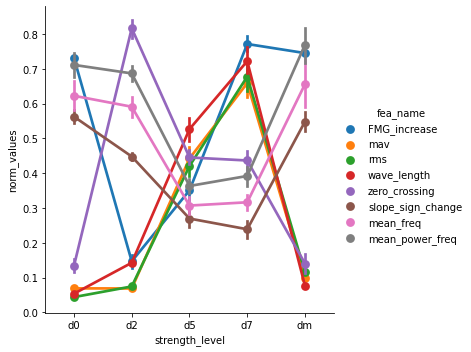

In [3]:
'''
1st index: subjects
2nd index: force level
3rd index: sensor channel
FMG + sEMG + ultrasound
'''
'''
feature name:
    FMG_increase
    sEMG:
        mav
        rms
        wave_length
        zero_crossing
        slope_sign_change
        mean_freq
        mean_power_freq
'''
# init a dataframe to store features
# get feature dataframe
sb_feature_df =pd.DataFrame(columns=('subject_name', 'label', 'FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq'))

# 使用boolean值索引出某一名受试者的实验数据
sb_data = signal_df.loc[signal_df.loc[:, 'subject_name'] == '\zpk2']
# 计算一名被试的所有特征
for row in sb_data.itertuples():
    # init data object
    FMG = FMGFeature(row.rest_signal[:, 0], row.active_signal[:, 0], 1223)
    sEMG = sEMGFeature(row.rest_signal[:, 1], row.active_signal[:, 1], 1223)
    # set window_length and step_increase
    FMG.signal_segment(2446, 500)
    sEMG.signal_segment(2446, 500)
    # print(row.label)
    temp_FMG_fea = FMG.FMG_increase()
    temp_mav = sEMG.feature_mav()
    temp_rms = sEMG.feature_rms()
    temp_wl = sEMG.feature_wl()
    temp_zc = sEMG.feature_zc()
    temp_ssc = sEMG.feature_ssc()
    temp_sEMG_freq_fea = sEMG.freq_features()
    temp_len = len(temp_FMG_fea)
    for i in range(temp_len):
        sb_feature_df = sb_feature_df.append({'subject_name': row.subject_name,
                                            'label': row.label,
                                            'FMG_increase': temp_FMG_fea[i],
                                            'mav': temp_mav[i],
                                            'rms': temp_rms[i],
                                            'wave_length': temp_wl[i],
                                            'zero_crossing': temp_zc[i],
                                            'slope_sign_change': temp_ssc[i],
                                            'mean_freq': temp_sEMG_freq_fea[i][0],
                                            'mean_power_freq': temp_sEMG_freq_fea[i][1]}, ignore_index=True)
        pass
    pass

# signal features normalization
sb_fea_norm_df = fea_df_norm(sb_feature_df, 'FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq')

# show figure
show_df = pd.DataFrame(columns = ('subject', 'strength_level', 'norm_values', 'fea_name'))

for row in sb_fea_norm_df.itertuples():    # go through each row
    for i in ['FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq']:
        show_df = show_df.append({'subject': row.subject_name,
                                'strength_level': row.label,
                                'norm_values': getattr(row, i),
                                'fea_name': i}, ignore_index=True)

sns.catplot(x = "strength_level",
            y = "norm_values",
            hue = "fea_name",
            data = show_df,
            kind = 'point')

In [10]:
# 处理所有数据
all_feature_df =pd.DataFrame(columns=('subject_name', 
                                    'height(cm)',
                                    'weight(kg)',
                                    'gender',
                                    'age',
                                    'sensor_channel',
                                    'label(kg)', 
                                    'FMG_increase', 
                                    'mav', 
                                    'rms', 
                                    'wave_length', 
                                    'zero_crossing', 
                                    'slope_sign_change', 
                                    'mean_freq', 
                                    'mean_power_freq'))

for row in signal_df.itertuples():
    FMG = FMGFeature(row.rest_signal[:, 0], row.active_signal[:, 0], 1223)
    sEMG = sEMGFeature(row.rest_signal[:, 1], row.active_signal[:, 1], 1223)
    FMG.signal_segment(2446, 500)
    sEMG.signal_segment(2446, 500)
    # print(row.label)
    temp_FMG_fea = FMG.FMG_increase()
    temp_mav = sEMG.feature_mav()
    temp_rms = sEMG.feature_rms()
    temp_wl = sEMG.feature_wl()
    temp_zc = sEMG.feature_zc()
    temp_ssc = sEMG.feature_ssc()
    temp_sEMG_freq_fea = sEMG.freq_features()
    temp_len = len(temp_FMG_fea)
    for i in range(temp_len):
        all_feature_df = all_feature_df.append({'subject_name': row.subject_name,
                                            'height(cm)': 190,
                                            'weight(kg)': 80,
                                            'gender': 1,
                                            'age': 25,
                                            'sensor_channel': row.sensor_channel,
                                            'label(kg)': row.label,
                                            'FMG_increase': temp_FMG_fea[i],
                                            'mav': temp_mav[i],
                                            'rms': temp_rms[i],
                                            'wave_length': temp_wl[i],
                                            'zero_crossing': temp_zc[i],
                                            'slope_sign_change': temp_ssc[i],
                                            'mean_freq': temp_sEMG_freq_fea[i][0],
                                            'mean_power_freq': temp_sEMG_freq_fea[i][1]}, ignore_index=True)
        pass
    pass

In [13]:
# 保存csv文件
# all_feature_df.to_csv("D:\code\data\iFEMG_data_set\zpk.csv")
print(all_feature_df.shape)
all_feature_df.head()

(2065, 15)


,subject_name,height(cm),weight(kg),gender,age,sensor_channel,label(kg),FMG_increase,mav,rms,wave_length,zero_crossing,slope_sign_change,mean_freq,mean_power_freq
0,\zpk1,190,80,1,25,bicps_br,0,1.442232,1.137284,1.365717,1.491583,0.330479,-0.181221,52.854988,68.637381
1,\zpk1,190,80,1,25,bicps_br,0,1.418860,1.005151,1.231245,1.340950,0.354757,-0.137653,52.737663,68.291478
2,\zpk1,190,80,1,25,bicps_br,0,1.394781,0.998467,1.221236,1.299189,0.340190,-0.139156,51.666465,66.703052
3,\zpk1,190,80,1,25,bicps_br,0,1.371055,0.912399,1.147685,1.148561,0.359613,-0.152677,50.897951,63.180631
4,\zpk1,190,80,1,25,bicps_br,0,1.345559,0.831169,1.000270,1.099665,0.408171,-0.151174,52.222854,64.365678


In [ ]:
# normalization
all_fea_norm_df = fea_df_norm(all_feature_df, 'FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq')

# show figure
show_df = pd.DataFrame(columns = ('subject', 'strength_level', 'norm_values', 'fea_name'))

for row in all_fea_norm_df.itertuples():    # go through each row
    for i in ['FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq']:
        show_df = show_df.append({'subject': row.subject_name,
                                'strength_level': row.label,
                                'norm_values': getattr(row, i),
                                'fea_name': i}, ignore_index=True)

sns.catplot(x = "strength_level",
            y = "norm_values",
            hue = "fea_name",
            data = show_df,
            kind = 'point')

In [12]:
# SVM model


# 使用boolean值索引出每种label对应的实验数据
# 排除第一列受试者名称和第二列label字符串
d0_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd0'].values[:, 2:]
d2_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd2'].values[:, 2:]
d5_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd5'].values[:, 2:]
d7_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd7'].values[:, 2:]
dm_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'dm'].values[:, 2:]

# 创建数据集和label
f_data = []
label = []
#    data = []
#    l_sit = np.zeros((f_sit.shape[0], 1))
#    l_stand = np.zeros((f_stand.shape[0], 1))
#    l_walk = np.zeros((f_walk.shape[0], 1))
#    l_stairA = np.zeros((f_stairA.shape[0], 1))
#    l_stairD = np.zeros((f_stairD.shape[0], 1))
#    l_rampA = np.zeros((f_rampA.shape[0], 1))
#    l_rampD = np.zeros((f_rampD.shape[0], 1))

for i in range(d0_data.shape[0]):
    label.append(0)

for i in range(d2_data.shape[0]):
    label.append(1)

for i in range(d5_data.shape[0]):
    label.append(2)

for i in range(d7_data.shape[0]):
    label.append(3)

for i in range(dm_data.shape[0]):
    label.append(4)

f_data = np.concatenate((d0_data, d2_data, d5_data, d7_data, dm_data), axis = 0)
print("data shape： ", f_data.shape)
print("label num: ", len(label))

# 划分训练集和测试集
train_data_r, test_data_r, train_label, test_label = train_test_split(f_data, label, test_size = 0.2, random_state = 0, stratify = label)
# train_data = preprocessing.normalize(train_data_r, norm = 'max')
# test_data = preprocessing.normalize(test_data_r, norm = 'max')
scaler = preprocessing.StandardScaler().fit(train_data_r)
train_data = scaler.transform(train_data_r)
test_data = scaler.transform(test_data_r)

# 记录开始训练时间
start_time = time.time()
print("start training, time: ", time.strftime("%Y--%m--%d %H:%M:%S", time.localtime(start_time)))

parameters = {'gamma':[0.001, 0.01, 0.1, 1], 'C':np.linspace(1, 100, 100)}
gs = GridSearchCV(svm.SVC(), parameters, refit = True, cv = 5, verbose = 1, n_jobs = -1)
gs.fit(train_data, train_label)
print('best parameter: ', gs.best_params_)
print('best efficience:', gs.best_score_)
print('report: ', classification_report(test_label, gs.predict(test_data)))


c = svm.SVC(C = gs.best_params_['C'], kernel = 'rbf', gamma = gs.best_params_['gamma'], decision_function_shape = 'ovr')# 
c.fit(train_data, train_label)
print("train acc:", c.score(train_data, train_label))
print('test acc:', c.score(test_data, test_label))
test_pred = c.predict(test_data)
print(confusion_matrix(test_label, test_pred))

end_time = time.time()
print("finish, time: ", time.strftime("%Y--%m--%d %H:%M:%S", time.localtime(end_time)))

'''
knn = KNeighborsClassifier()
knn.fit(train_data, train_label)
print(knn.score(train_data, train_label))
print(knn.score(test_data, test_label))

test_pred = knn.predict(test_data)
name = ['sit', 'stand', 'walk', 'stairA', 'stairD', 'rampA', 'rampD']
print(confusion_matrix(test_label, test_pred))
'''



data shape：  (2130, 8)
label num:  2130
start training, time:  2022--09--25 17:29:39
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
best parameter:  {'C': 17.0, 'gamma': 1}
best efficience: 0.9753613938243919
report:                precision    recall  f1-score   support

           0       0.98      0.97      0.97        88
           1       1.00      1.00      1.00        93
           2       0.96      0.96      0.96       103
           3       0.96      0.97      0.96        98
           4       0.95      0.95      0.95        44

    accuracy                           0.97       426
   macro avg       0.97      0.97      0.97       426
weighted avg       0.97      0.97      0.97       426

train acc: 0.9964788732394366
test acc: 0.971830985915493
[[85  0  1  0  2]
 [ 0 93  0  0  0]
 [ 0  0 99  4  0]
 [ 0  0  3 95  0]
 [ 2  0  0  0 42]]
finish, time:  2022--09--25 17:30:01


"\nknn = KNeighborsClassifier()\nknn.fit(train_data, train_label)\nprint(knn.score(train_data, train_label))\nprint(knn.score(test_data, test_label))\n\ntest_pred = knn.predict(test_data)\nname = ['sit', 'stand', 'walk', 'stairA', 'stairD', 'rampA', 'rampD']\nprint(confusion_matrix(test_label, test_pred))\n"